In [3]:
import tensorflow as tf
import os

In [2]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
cpus = tf.config.experimental.list_physical_devices('GPU')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

In [4]:
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

C:\Users\KIIT\AppData\Local\Temp\ipykernel_31772\3538499753.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'dataset'

In [7]:
os.listdir(os.path.join(data_dir, 'overlapping'))

['2.png',
 '3-resized.png',
 '3.png',
 '4-resized.png',
 '4-transformed.png',
 '4.png',
 'rect_bar_output.jpg',
 'rect_CAB_output.jpg',
 'row_16.png',
 'row_17.png',
 'row_18.png',
 'row_19.png',
 'row_20.png',
 'row_21.png',
 'row_22.png',
 'row_23.png',
 'row_31.png',
 'row_32.png',
 'row_33.png']

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Load Data

In [50]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [51]:
# --- 1. Define 'data' ---
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred', 
    label_mode='categorical',
    image_size=(256, 256),  
    batch_size=8, 
)

Found 63 files belonging to 4 classes.


In [52]:
data_iterator = data.as_numpy_iterator()

In [53]:
batch = data_iterator.next()

In [54]:
batch[0].shape

(8, 256, 256, 3)

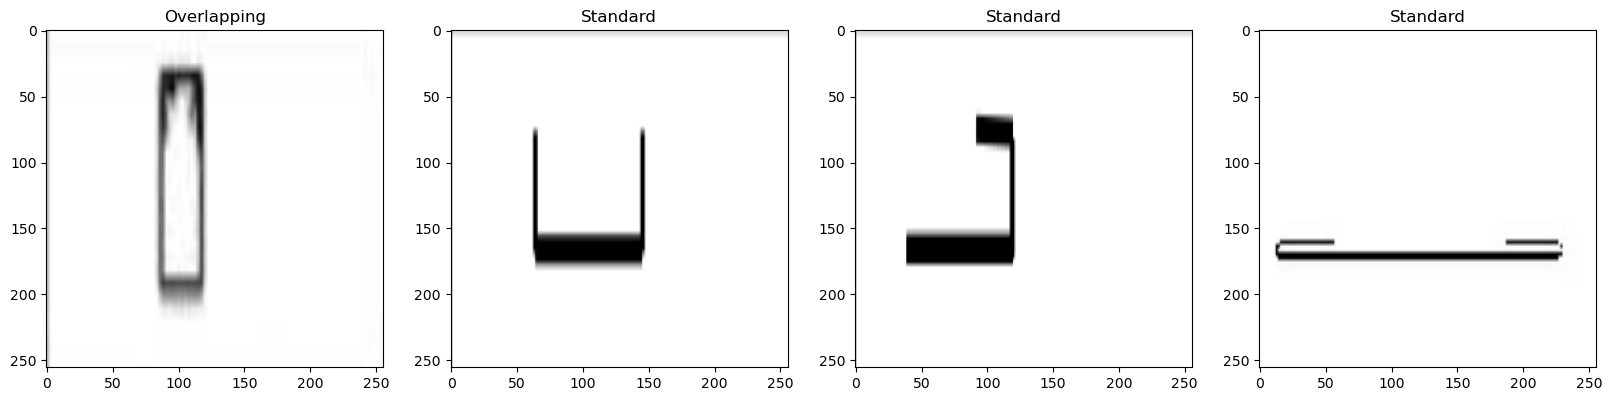

In [55]:
class_names = {
    0: "Circular",
    1: "Intersecting",
    2: "Standard",
    3: "Overlapping",
}


fig, ax = plt.subplots(ncols=4, figsize=(20, 25))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # Convert NumPy array to a hashable type (e.g., integer)
    label_index = np.argmax(batch[1][idx])  # Get index of the highest probability class
    ax[idx].title.set_text(class_names.get(label_index, "Unknown"))

    # Add x and y ticks (adjust values based on your image dimensions)
    ax[idx].set_xticks(np.arange(0, img.shape[1], 50))  # Ticks every 50 pixels on x-axis
    ax[idx].set_yticks(np.arange(0, img.shape[0], 50))  # Ticks every 50 pixels on y-axis

    # Optionally, label the ticks with pixel values
    ax[idx].set_xticklabels(np.arange(0, img.shape[1], 50))
    ax[idx].set_yticklabels(np.arange(0, img.shape[0], 50))

plt.show()

### Scale Data

In [56]:
data = data.map(lambda x,y: (x/255, y))
# important since it helps to perform transformation to convert image min to 0 and max to 1
# important while working with data pipeline

In [57]:
data.as_numpy_iterator().next()

(array([[[[0.73333335, 0.73333335, 0.73333335],
          [0.7636106 , 0.7636106 , 0.7636106 ],
          [0.87137717, 0.87137717, 0.87137717],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         [[0.73333335, 0.73333335, 0.73333335],
          [0.7636106 , 0.7636106 , 0.7636106 ],
          [0.87137717, 0.87137717, 0.87137717],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         [[0.73333335, 0.73333335, 0.73333335],
          [0.7636106 , 0.7636106 , 0.7636106 ],
          [0.87137717, 0.87137717, 0.87137717],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         ...,
 
         [[0.6901961 , 0.6901961 , 0.6901961 ],
          [0.72589

### Split Data

In [58]:
len(data) # num of batches

8

In [59]:
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+2
test_size = int(len(data)*.1)+1

In [61]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Established train, test and val partition

In [62]:
train_labels = np.concatenate([y for x, y in train], axis=0)
val_labels = np.concatenate([y for x, y in val], axis=0)
test_labels = np.concatenate([y for x, y in test], axis=0)

# One-hot encode the labels (if needed for your model)
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

### Building the model

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [64]:
num_classes = 4
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

C:\Users\KIIT\anaconda3\envs\ai_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
logdir = 'logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.2792 - loss: 1.9572 - val_accuracy: 0.3333 - val_loss: 1.3105
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.4292 - loss: 1.2542 - val_accuracy: 0.6667 - val_loss: 1.1708
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4958 - loss: 1.3034 - val_accuracy: 0.3333 - val_loss: 1.1023
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.4417 - loss: 1.2990 - val_accuracy: 0.5000 - val_loss: 1.1794
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8000 - loss: 0.9461 - val_accuracy: 0.5833 - val_loss: 1.0690
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5458 - loss: 1.0296 - val_accuracy: 0.7917 - val_loss: 0.7830
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.6208 - loss: 0.9050 - val_accuracy: 0.4583 - val_loss: 0.9053
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.6667 - loss: 0.7409 - val_accuracy: 0.9167 - val_loss:

In [70]:
hist.history

{'accuracy': [0.34375,
  0.34375,
  0.46875,
  0.46875,
  0.71875,
  0.53125,
  0.625,
  0.78125,
  0.875,
  0.84375,
  0.90625,
  0.9375,
  0.9375,
  0.9375,
  0.96875,
  0.96875,
  0.96875,
  1.0,
  1.0,
  1.0],
 'loss': [1.8937122821807861,
  1.2902276515960693,
  1.2757771015167236,
  1.2999399900436401,
  0.976733386516571,
  1.0119081735610962,
  0.9031525254249573,
  0.597897469997406,
  0.5641507506370544,
  0.4970129132270813,
  0.2666117548942566,
  0.18016624450683594,
  0.1786714345216751,
  0.12179651856422424,
  0.09892131388187408,
  0.07162326574325562,
  0.1028701588511467,
  0.03863086923956871,
  0.005186659283936024,
  0.0004730354994535446],
 'val_accuracy': [0.3333333432674408,
  0.6666666865348816,
  0.3333333432674408,
  0.5,
  0.5833333134651184,
  0.7916666865348816,
  0.4583333432674408,
  0.9166666865348816,
  1.0,
  0.8333333134651184,
  0.875,
  0.9583333134651184,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [1.3104819059371948,
 

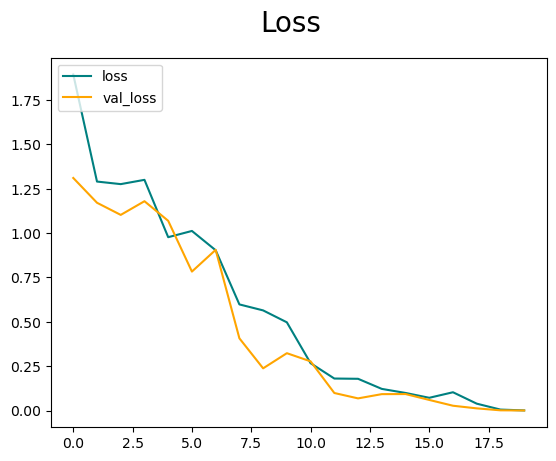

In [71]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

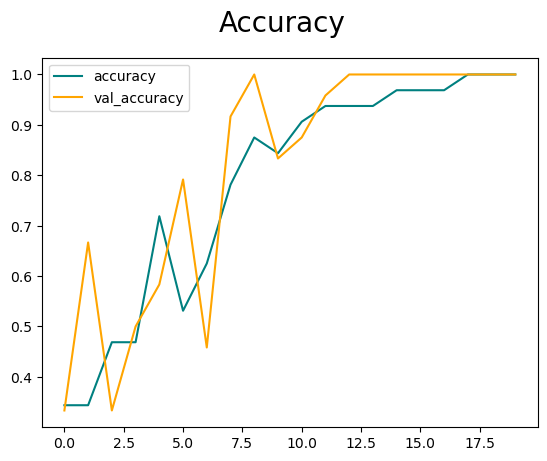

In [72]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation

In [73]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [74]:
# Establishing instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [75]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [76]:
print(f'Precision:{pre.result()}, Recall:{re.result().numpy()}, Acuraccy:{acc.result().numpy}')

Precision:1.0, Recall:1.0, Acuraccy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


### Testing

In [1]:
import cv2

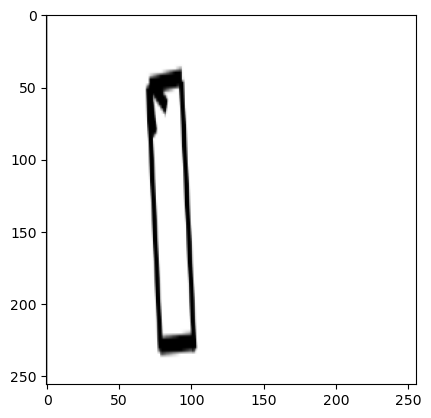

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image belong to the Overlapping class


In [81]:
# Load and preprocess the image
img = cv2.imread('Shapes/row_32.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class
predict = model.predict(np.expand_dims(resize/255, 0))

class_names = ['Circular', 'Intersecting', 'Standard', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

### Saving the model

In [82]:
from tensorflow.keras.models import load_model

In [85]:
model.save('4_class_improved.keras')

In [2]:
prediction = tf.keras.models.load_model('4_class_improved.keras')

NameError: name 'tf' is not defined

In [87]:
prediction

<Sequential name=sequential_1, built=True>

In [88]:
yhatnew = prediction.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


In [89]:
class_names = ['Circular', 'Intersecting', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

Image belong to the Overlapping class
